In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


import cv2
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import tensorflow.keras.backend as K

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm import tqdm
from collections import Counter
from PIL import Image
from itertools import groupby


In [4]:
file_path = "words_new.txt"
with open(file_path) as f:
    lines = f.readlines()

label_raw = lines[18:]  # Skipping the initial lines that are comments

image_texts = []
image_paths = []
default_path = "iam_words/words/"
for label in label_raw:
    parts = label.strip().split()  # Using strip() to remove any leading/trailing whitespaces
    if len(parts) < 9:  # Check if the line has fewer parts than expected
        print(f"Skipping line due to unexpected format: {label}")
        continue  # Skip this iteration and move to the next line
    if parts[1] == "ok":
        image_texts.append(parts[-1])
        image_id = parts[0]
        subdir1 = image_id.split("-")[0]
        subdir2 = f"{subdir1}-{image_id.split('-')[1]}"
        image_paths.append(os.path.join(default_path, subdir1, subdir2, f"{image_id}.png"))


In [5]:
image_texts=image_texts
image_paths=image_paths

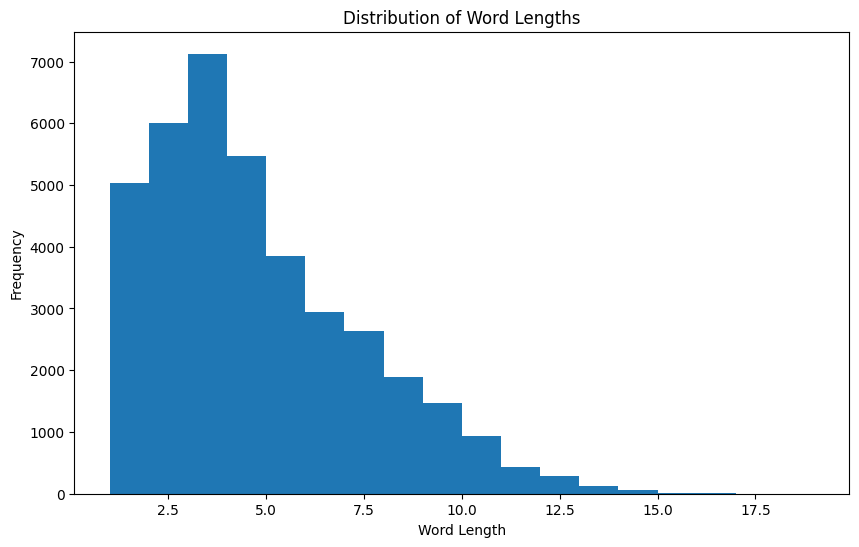

In [6]:
word_lengths = [len(word) for word in image_texts]
plt.figure(figsize=(10, 6))
plt.hist(word_lengths, bins=range(1, max(word_lengths) + 1))
plt.title('Distribution of Word Lengths')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.show()


sth

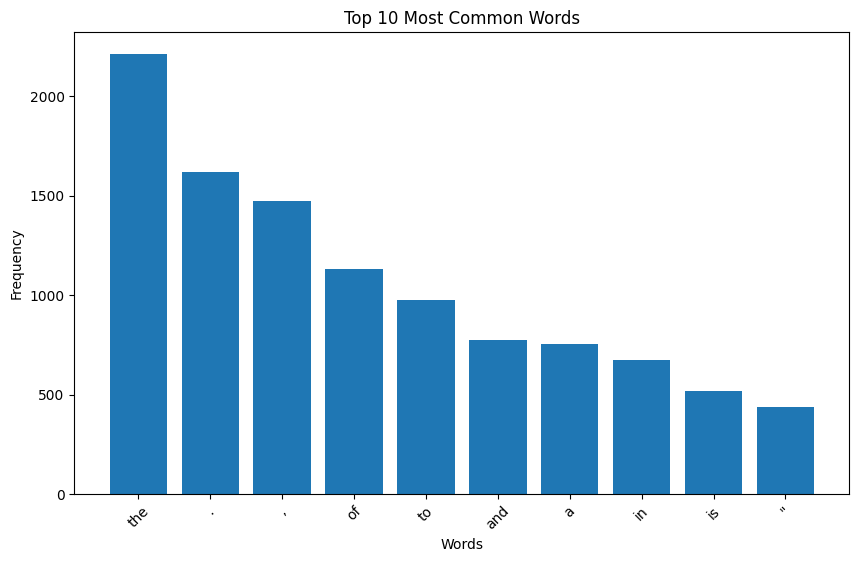

In [7]:
from collections import Counter
word_counts = Counter(image_texts)
common_words = word_counts.most_common(10)
words, counts = zip(*common_words)

plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.title('Top 10 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


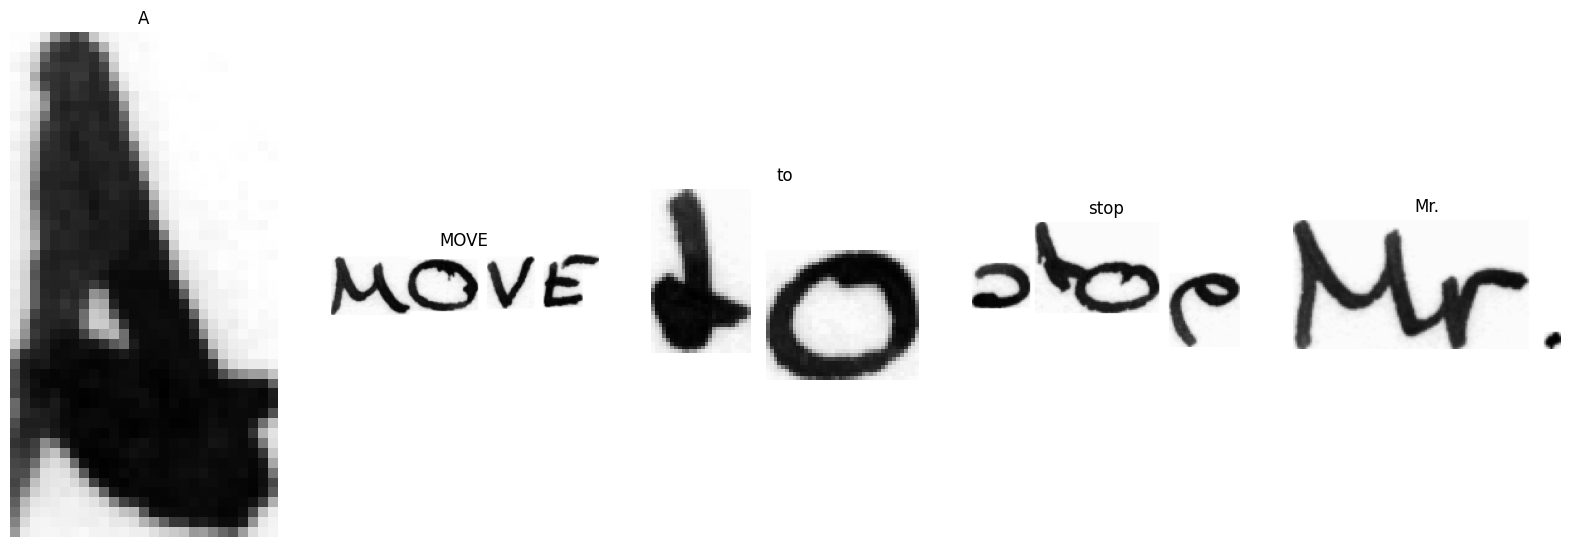

In [8]:
fig, axes = plt.subplots(1, 5, figsize=(20, 10))
for ax, (path, label) in zip(axes, zip(image_paths[:5], image_texts[:5])):
    image = plt.imread(path)
    ax.imshow(image, cmap='gray')
    ax.set_title(label)
    ax.axis('off')
plt.show()


The presence of ".", ",", "of", "to", "and", "a", "in", "is", "=", as the top words is indicative of common English language usage, particularly in written text where these words and symbols are frequently used for basic sentence structure and meaning.

The right-skewed distribution of word lengths suggests that while most words are relatively short, there's a long tail of longer words. This is typical of many natural language datasets, where a large number of unique words are used infrequently, contributing to a long tail in the distribution. For handwriting recognition, this implies that your model needs to handle a wide range of word lengths, from short to very long words, which can be challenging in terms of both recognizing the individual characters and understanding the spatial relationships between them in longer words.

In [9]:
corrupt_images = []

for path in image_paths:
    try:
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
    except:
        corrupt_images.append(path)

corrupt_images, len(corrupt_images)

(['iam_words/words/a01\\a01-117\\a01-117-05-02.png'], 1)

In [10]:
for path in corrupt_images:
    
    corrupt_index = image_paths.index(path)
    del image_paths[corrupt_index]
    del image_texts[corrupt_index]
    

In [11]:

### get vocabulary for the current dataset
vocab = set("".join(map(str, image_texts)))
print(sorted(vocab))

['!', '"', '#', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [12]:

max_label_len = max([len(str(text)) for text in image_texts])
max_label_len

19

maximum label length among your images' text labels is 19 characters. This information is crucial for several reasons:

Model Input and Output: Knowing the maximum label length helps in defining the architecture of your neural network, especially the output dimensions of your model. For a handwriting recognition model, especially one based on a sequence-to-sequence framework like CTC (Connectionist Temporal Classification), you need to ensure that the model can handle sequences of this length.

Padding Sequences: When training your model, you'll likely need to pad the sequences to ensure that all of them have the same length. This is important for batching purposes, as deep learning models require inputs to be of a uniform size. Knowing the maximum label length allows you to apply the correct amount of padding to each sequence.

Performance Considerations: The maximum label length might also have implications for your model's performance. Longer sequences can be more challenging to predict accurately due to the increased possibilities for errors and the dependence on longer-term dependencies between characters. You might need to consider model architectures that are particularly good at capturing these dependencies, such as RNNs with LSTM or GRU layers.

In [13]:
char_list = sorted(vocab)

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
    
    return pad_sequences([dig_lst], maxlen=max_label_len, padding='post', value=len(char_list))[0]

padded_image_texts = list(map(encode_to_labels, image_texts))

padded_image_texts[0]

array([24, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76,
       76, 76])

This step is essential for a few reasons:

Numerical Representation: Deep learning models work with numerical data, so converting your textual data into a numerical format is a necessary preprocessing step. Your choice of encoding each character to its index in a sorted list of all characters (char_list) is a common and effective approach.

Sequence Padding: By padding the sequences, you ensure that all your input data to the model has a uniform shape. This is crucial for batching and processing through your neural network layers, which require consistent input dimensions. You've chosen 'post' padding, which adds any necessary padding at the end of the sequences, ensuring that the beginning of each text (where the actual data is) aligns.

Handling Unknown Characters: Your try-except block within the encode_to_labels function is a good practice for handling characters that might not be present in your char_list. If you encounter such a character, your current setup will silently ignore it. Depending on your application, you might want to log these instances or add a special token to your char_list to represent unknown characters.

Preparation for Model Training: This encoding and padding process prepares your dataset for model training, specifically for models that rely on a fixed input size, such as Convolutional Neural Networks (CNNs) combined with Recurrent Neural Networks (RNNs) for sequence prediction tasks like handwriting recognition.

